In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Downloading the data from source to colab

In [2]:
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate

--2024-04-28 03:34:04--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  18.7MB/s    in 1m 46s  

2024-04-28 03:35:51 (18.6 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [ ]:
!pip install tifffile
!pip install imgaug

In [4]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import imgaug.augmenters as iaa
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Dropout, Input
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
from keras.applications import VGG19
from keras.applications import VGG16
from keras.applications import Xception
from keras.applications import InceptionV3
from prettytable import PrettyTable
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
# Extracting all the files from the zip folder
with zipfile.ZipFile('EuroSATallBands.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# To find the size of the folder extracted
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size / (1024 ** 3)  # Convert bytes to gigabytes

folder_path = '/content/ds'  # Change this to the path of the folder you want to get the size of
folder_size_gb  = get_folder_size(folder_path)
print(f"The size of the dataset folder '{folder_path}' is {folder_size_gb:.2f} GB.")

The size of the dataset folder '/content/ds' is 2.70 GB.


In [7]:
# this function extracts all image paths and labels from the given directory
def extract_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []

    # Walk through the dataset directory structure
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
          # Construct the full path to the image
          image_path = os.path.join(root, file)
          # Append the image path to the list
          image_paths.append(image_path)
          # Append the label (class name) to the labels list
          labels.append(image_path.split('/')[-2])
    return image_paths, labels

dataset_path = '/content/ds'
image_paths, labels = extract_image_paths_and_labels(dataset_path)

In [8]:
# creating dataframe using image paths and image labels.
data = pd.DataFrame(zip(image_paths,labels),columns = ['image_path','label'])
data.head()

,image_path,label
0,/content/ds/images/remote_sensing/otherDataset...,Pasture
1,/content/ds/images/remote_sensing/otherDataset...,Pasture
2,/content/ds/images/remote_sensing/otherDataset...,Pasture
3,/content/ds/images/remote_sensing/otherDataset...,Pasture
4,/content/ds/images/remote_sensing/otherDataset...,Pasture


In [9]:
data.shape

(27000, 2)

There are 27000 images in the dataset.

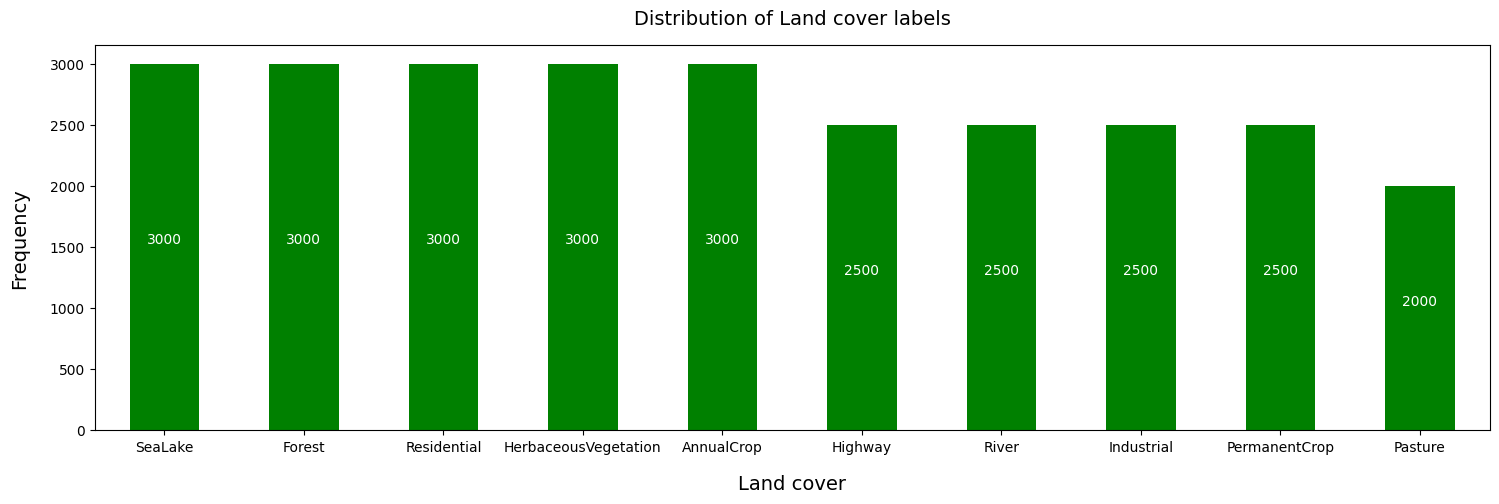

In [10]:
plt.figure(figsize= (18,5))
ax = data['label'].value_counts().plot(kind = 'bar',color='green')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()/2, str(i.get_height()),
            ha='center', va='bottom',color='white')

plt.xlabel('Land cover',labelpad=15,size=14)
plt.ylabel('Frequency',labelpad=15,size=14)
plt.title('Distribution of Land cover labels',pad=15,size=14)
plt.xticks(rotation=0)
plt.show()

From the above plot it can be observed that the Pasture image label has least number of images in dataset and whereas the below mentioned labels has the highest number of images.<br>
* Herbaceous Vegetation
* Forest
* Sealake
* Annual Crop
* Residential

In [11]:
num_channels = []

# This code block extracts the number of channels present in each image
# and appends to list num_channels.

for tif_file in tqdm(data['image_path'].tolist()):
  tif_data = tifffile.imread(tif_file)
  num_channels.append(tif_data.shape[2])  # extract the number of channels of image

100%|██████████| 27000/27000 [00:13<00:00, 1963.55it/s]


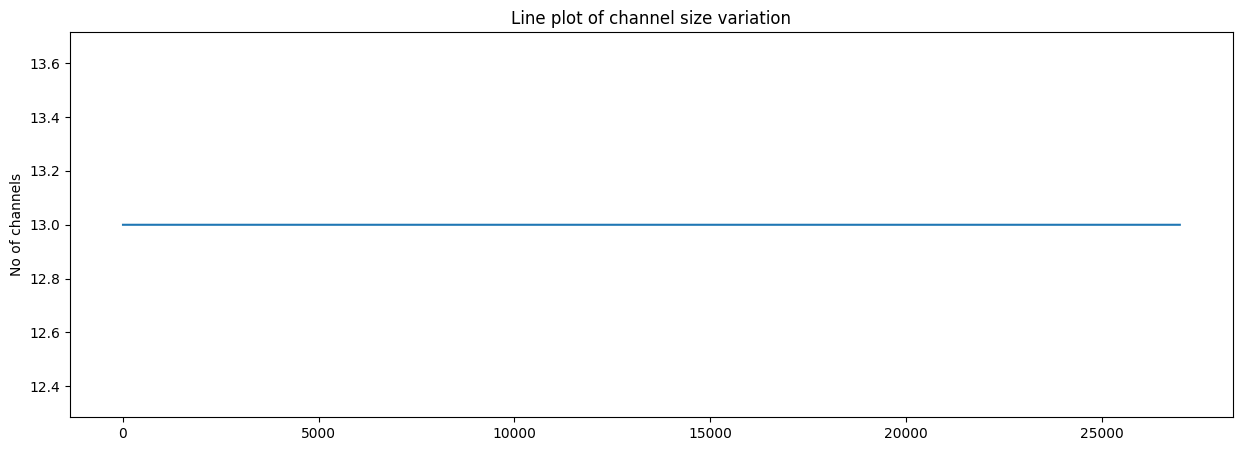

In [12]:
plt.figure(figsize= (15,5))
plt.plot(num_channels)

plt.ylabel('No of channels')
plt.title('Line plot of channel size variation')
plt.show()

It can be observed that all the images have 13 channels.

In [13]:
# Sampling 15 samples randomly from the dataset to view the images.
sample_data = data.sample(15,random_state=16)

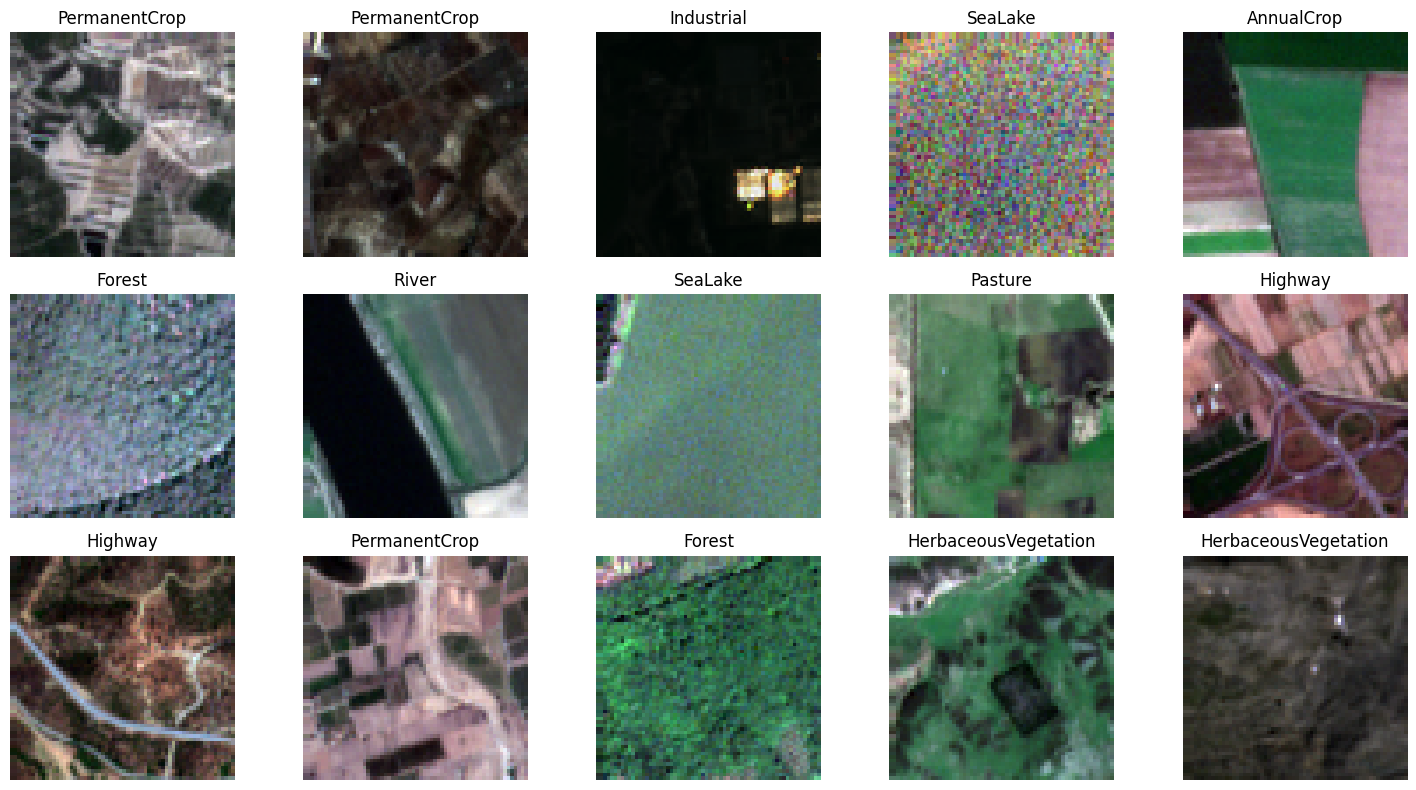

In [14]:
# Displaying the images with RGB channels for the randomly sampled data.
plt.figure(figsize=(15,8))
i = 0
for j in sample_data['image_path'].tolist():
  tif_data = tifffile.imread(j)
  bands    = np.transpose(tif_data, (2, 0, 1))[[3,2,1],:,:] # Extracting RGB Channels
  scaled_bands = [(band - band.min()) / (band.max() - band.min()) for band in bands]
  rgb_image = np.dstack(scaled_bands)
  plt.subplot(3,5,i+1)
  plt.axis('off')
  plt.imshow(rgb_image)
  plt.title(sample_data['label'].tolist()[i])
  i = i + 1

plt.tight_layout()
plt.show()

In [15]:
# Function to get height and width of an image
def get_image_dimensions(image_path):
    tif_data = tifffile.imread(image_path)
    height, width, _ = tif_data.shape
    return height, width

In [16]:
# Applying the function to all images in the dataset
data['height'], data['width'] = zip(*data['image_path'].apply(get_image_dimensions))
# Displaying the first 5 rows of the dataset.
data.head()

,image_path,label,height,width
0,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64
1,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64
2,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64
3,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64
4,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64


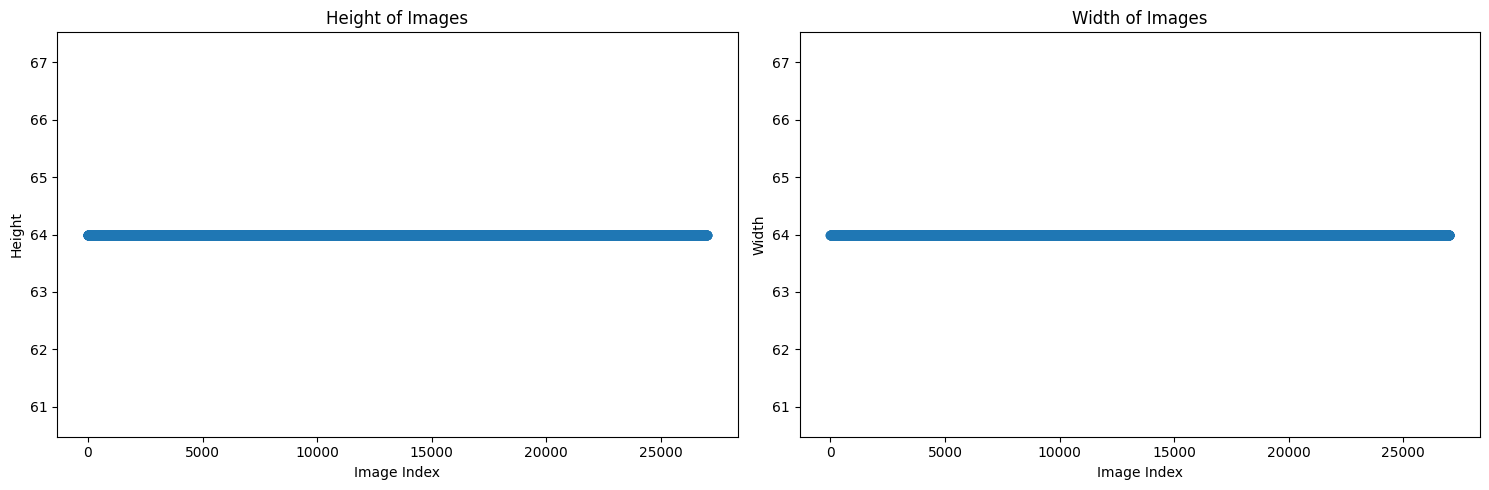

In [17]:
# Plotting heights and widths of all the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(data['height'], marker='o', linestyle='-')
plt.title('Height of Images')
plt.xlabel('Image Index')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
plt.plot(data['width'], marker='o', linestyle='-')
plt.title('Width of Images')
plt.xlabel('Image Index')
plt.ylabel('Width')

plt.tight_layout()
plt.show()

It can be observed that the heights and widths of all the images of the dataset are 64 and 64 respectively.

In [18]:
# Function to analyze pixel intensities for an image
def analyze_pixel_intensities(image_path):
    # Reading the image
    image = tifffile.imread(image_path)
    # Flattening the image array to 1D
    flat_image = image.flatten()
    # Calculating mean
    mean_intensity = np.mean(flat_image)
    return mean_intensity

In [19]:
# Applying the function to all images in the dataset
data['mean_intensity'] = data['image_path'].apply(analyze_pixel_intensities)
# Displaying first 5 rows of the dataset.
data.head()

,image_path,label,height,width,mean_intensity
0,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64,1732.932392
1,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64,1639.286809
2,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64,1705.965839
3,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64,1563.685584
4,/content/ds/images/remote_sensing/otherDataset...,Pasture,64,64,1683.637113


In [20]:
max_intensity = data['mean_intensity'].max()
min_intensity = data['mean_intensity'].min()

In [21]:
# Splitting the data into training and testing sets in the ratio of 80:20 respectively
train, test  = train_test_split(data, test_size=0.20, random_state=42,stratify=data['label'])

In [22]:
# Define augmentation pipeline for training data
train_augmentations = iaa.Sequential([iaa.Fliplr(0.5),
                                      iaa.Affine(scale=(0.8, 1.2),
                                                 shear=(-16, 16),
                                                 order=[0, 1])])
# Define augmentation pipeline for test data (you can keep it empty if no augmentations are desired)
test_augmentations = None  # No augmentations for test data

In [23]:
class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, image_size, num_channels,
                 augmentations=None):
        """
        Constructor for CustomDataGenerator.
        Args:
            dataframe: DataFrame containing image paths and labels.
            batch_size: Size of each batch.
            image_size: Size to which images are resized.
            num_channels: Number of channels in the images.
            shuffle: Whether to shuffle the data after each epoch.
            augmentations: List of imgaug augmenters to be applied.
        """
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_channels = num_channels
        self.augmentations = augmentations if augmentations else []
        # Initialize LabelEncoder to encode labels
        self.label_encoder = LabelEncoder()
        # Encode labels using LabelEncoder
        self.labels = self.label_encoder.fit_transform(dataframe['label'])
        # Shuffle indexes after each epoch
        self.indexes = np.arange(len(self.dataframe))

    def __len__(self):
        """
        Returns the number of batches in the dataset.
        """
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates one batch of data.
        Args:
            index: Index of the batch.
        Returns:
            X: Input data (images).
            y: Target data (labels).
        """
        # Select batch indexes
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Retrieve corresponding rows from DataFrame
        df_batch = self.dataframe.iloc[indexes]
        # Preprocess images and labels
        X, y = self.__data_generation(df_batch)
        return X, y

    def __apply_augmentations(self, img):
        """
        Applies data augmentations to the image.
        Args:
            img: Input image.
        Returns:
            Augmented image.
        """
        if self.augmentations:
            # Apply augmentation pipeline
            seq = iaa.Sequential(self.augmentations)
            img = seq.augment_image(img)
        return img

    def __data_generation(self, df_batch):
        """
        Preprocesses a batch of images and labels.
        Args:
            df_batch: DataFrame containing batch of image paths and labels.
        Returns:
            X: Preprocessed input data (images).
            y: Preprocessed target data (labels).
        """
        # Initialize empty arrays for input data (images) and target data (labels)
        X = np.empty((len(df_batch), *self.image_size, self.num_channels))
        y = self.label_encoder.transform(df_batch['label'])

        for i, (_, row) in enumerate(df_batch.iterrows()):
            # Load and preprocess image using tifffile
            img = tifffile.imread(row['image_path'])
            # Normalize pixel values
            img = (img - min_intensity)/(max_intensity-min_intensity)
            # Resize images
            img = np.resize(img, self.image_size + (self.num_channels,))
            # Apply augmentations
            img = self.__apply_augmentations(img)
            # Store preprocessed image in X
            X[i,] = img

        # Convert labels to one-hot encoding
        y = to_categorical(y, num_classes=len(self.label_encoder.classes_))
        return X, y

    def get_class_labels(self):
        """
        Returns the class labels.
        """
        return self.label_encoder.classes_

In [24]:
batch_size  = 16
num_classes = 10

In [25]:
# Initialize train and test generators using CustomDataGenerator
# train and test are DataFrames containing image paths and labels for training and testing data respectively
# Set batch_size to 16, image_size to (64, 64), and num_channels to 13
# batch_size determines the number of samples in each batch
# image_size specifies the target size for the images
# num_channels defines the number of channels in the images (13 in this case)

train_generator = CustomDataGenerator(train, batch_size=batch_size,
                                      image_size=(64, 64), num_channels=13,
                                      augmentations=train_augmentations)
test_generator  = CustomDataGenerator(test, batch_size=batch_size,
                                      image_size=(64, 64), num_channels=13,
                                      augmentations=test_augmentations)

In [26]:
with open('/content/drive/MyDrive/Landcover_recognition/class_labels.pkl', 'wb') as f:
    pickle.dump(train_generator.get_class_labels(), f)

In [35]:
# Defining your custom model architecture
# Sequential model allows you to stack layers sequentially
# Conv2D layers create convolutional layers with specified number of filters, kernel size, and activation function
# MaxPooling2D layers perform max pooling operation to downsample the feature maps
# Flatten layer flattens the input into a one-dimensional array
# Dense layers are fully connected layers with specified number of units and activation function
# Input shape is (64, 64, 13) as specified, where 13 is the number of channels

# 1. Training using Custom model

model_name = "land_cover_classification"
model = Sequential(name=model_name, layers=[
    Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 13)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Here, num_classes is the number of output classes
])

# Compiling the model
# Adam optimizer is used with specified learning rate
# Categorical crossentropy is used as the loss function for multi-class classification
# Metrics are set to categorical accuracy to monitor model performance during training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Printing model summary
# Model summary provides information about the architecture, number of parameters, etc.
model.summary(line_length=100,show_trainable=True)

Model: "land_cover_classification"
_______________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        Trainable  
 conv2d_574 (Conv2D)                         (None, 62, 62, 128)                     15104          Y          
                                                                                                               
 max_pooling2d_28 (MaxPooling2D)             (None, 31, 31, 128)                     0              Y          
                                                                                                               
 conv2d_575 (Conv2D)                         (None, 29, 29, 64)                      73792          Y          
                                                                                                               
 max_pooling2d_29 (MaxPooling2D)             (None, 14, 14, 64)      

**Callbacks**<br>

1.   ModelCheckpoint <br>
     * This callback is used to save the model's weights when the
       validation categorical accuracy improves.<br>
     * monitor='val_categorical_accuracy' specifies that the
       callback will monitor the validation categorical accuracy.<br>
     * save_best_only=True ensures that only the best model  
       weights are saved (those that minimize the monitored quantity)  <br>
     * verbose=1 prints a message when the best weights are   
       saved.<br>       

2.   EarlyStopping<br>
     * This callback is used to stop training if the validation
       categorical accuracy does not improve after a certain number of epochs<br>
     * monitor='val_categorical_accuracy' specifies that the
       callback will monitor the validation categorical accuracy<br>
     * patience=3 means training will stop if the validation
       categorical accuracy does not improve after 3 epochs<br>
     * verbose=1 prints a message when training stops due to lack
       of improvement.<br>

3.  ReduceLROnPlateau<br>
     * It is a technique used to dynamically adjust the learning
       rate during training based on the performance of a specified metric, with the goal of improving convergence and preventing overfitting.<br>
     * monitor: Metric to monitor during training (e.g.,  
       validation categorical accuracy).<br>
     * factor: Factor by which the learning rate will be reduced
       when the monitored metric stops improving (e.g., 0.95).<br>
     * patience: Number of epochs with no improvement before
       reducing the learning rate (e.g., 2).<br>
     * verbose: Controls the verbosity of training output (e.g., 1
       for printing messages about learning rate reduction).<br>
     * mode: Specifies whether to maximize or minimize the       monitored metric (e.g., 'max' for maximizing validation  categorical accuracy).  









In [36]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Landcover_recognition/custom_model.h5',
                             monitor='val_categorical_accuracy',mode='max',
                             save_best_only=True,verbose=1)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, verbose=1,mode='max')
lr_handling    = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.95,
                                   patience=2,verbose=1,mode='max')
model.fit(train_generator,
          epochs=60,
          validation_data=test_generator,
          callbacks=[checkpoint, early_stopping,lr_handling],verbose=1)

Epoch 1/60
1350/1350 [==============================] - ETA: 0s - loss: 1.2795 - categorical_accuracy: 0.5299
Epoch 1: val_categorical_accuracy improved from -inf to 0.69889, saving model to /content/drive/MyDrive/Landcover_recognition/custom_model.h5
1350/1350 [==============================] - 72s 50ms/step - loss: 1.2795 - categorical_accuracy: 0.5299 - val_loss: 0.8433 - val_categorical_accuracy: 0.6989 - lr: 1.0000e-04
Epoch 2/60
1350/1350 [==============================] - ETA: 0s - loss: 0.7573 - categorical_accuracy: 0.7352
Epoch 2: val_categorical_accuracy improved from 0.69889 to 0.79537, saving model to /content/drive/MyDrive/Landcover_recognition/custom_model.h5
1350/1350 [==============================] - 66s 49ms/step - loss: 0.7573 - categorical_accuracy: 0.7352 - val_loss: 0.6324 - val_categorical_accuracy: 0.7954 - lr: 1.0000e-04
Epoch 3/60
1350/1350 [==============================] - ETA: 0s - loss: 0.5995 - categorical_accuracy: 0.7989
Epoch 3: val_categorical_accura

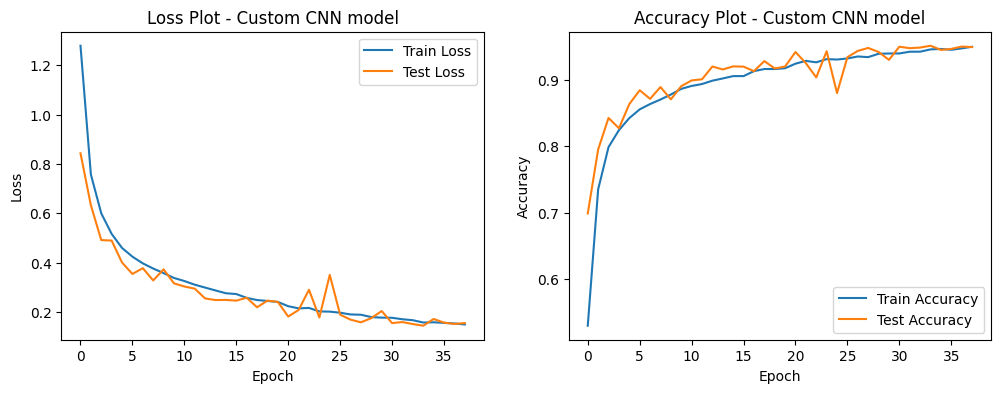

In [37]:
# Plot training and test  loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot - Custom CNN model')
plt.legend()

# Plot training and test accuracy
plt.subplot(1,2,2)
plt.plot(model.history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_categorical_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot - Custom CNN model')
plt.legend()

plt.show()

In [38]:
# 3. Transfer Learning using VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = True

input = Input(shape=(64, 64, 13)) # Defining input layer
x = Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 13))(input)
x = base_model(x) # Passing the modified input through the base model
x = Flatten()(x)  # Flattening the output
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x) # Output layer

vgg19_model = Model(name='Landcover_classification',inputs=input, outputs=output)
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy', metrics=['categorical_accuracy']) # Compiling the model
vgg19_model.summary(line_length=100,show_trainable=True)

80134624/80134624 [==============================] - 1s 0us/step
Model: "Landcover_classification"
_______________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        Trainable  
 input_14 (InputLayer)                       [(None, 64, 64, 13)]                    0              Y          
                                                                                                               
 conv2d_578 (Conv2D)                         (None, 64, 64, 3)                       354            Y          
                                                                                                               
 vgg19 (Functional)                          (None, 2, 2, 512)                       20024384       Y          
                                                                                                               
 flat

In [39]:
checkpoint     = ModelCheckpoint('/content/drive/MyDrive/Landcover_recognition/vgg19_model.h5',
                                 monitor='val_categorical_accuracy', save_best_only=True, verbose=1,mode='max')
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, verbose=1,mode='max')
lr_handling    = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.95,
                                   patience=2,verbose=1,mode='max')
vgg19_model.fit(train_generator,
                epochs=60,
                validation_data=test_generator,
                callbacks=[checkpoint, early_stopping,lr_handling],verbose=1)

Epoch 1/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.6838 - categorical_accuracy: 0.7632
Epoch 1: val_categorical_accuracy improved from -inf to 0.85611, saving model to /content/drive/MyDrive/Landcover_recognition/vgg19_model.h5
1350/1350 [==============================] - 101s 69ms/step - loss: 0.6838 - categorical_accuracy: 0.7632 - val_loss: 0.4247 - val_categorical_accuracy: 0.8561 - lr: 1.0000e-04
Epoch 2/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.3727 - categorical_accuracy: 0.8805
Epoch 2: val_categorical_accuracy improved from 0.85611 to 0.90426, saving model to /content/drive/MyDrive/Landcover_recognition/vgg19_model.h5
1350/1350 [==============================] - 68s 50ms/step - loss: 0.3727 - categorical_accuracy: 0.8805 - val_loss: 0.3236 - val_categorical_accuracy: 0.9043 - lr: 1.0000e-04
Epoch 3/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.3061 - categorical_accuracy: 0.9032
Epoch 3: val_categorical_accurac

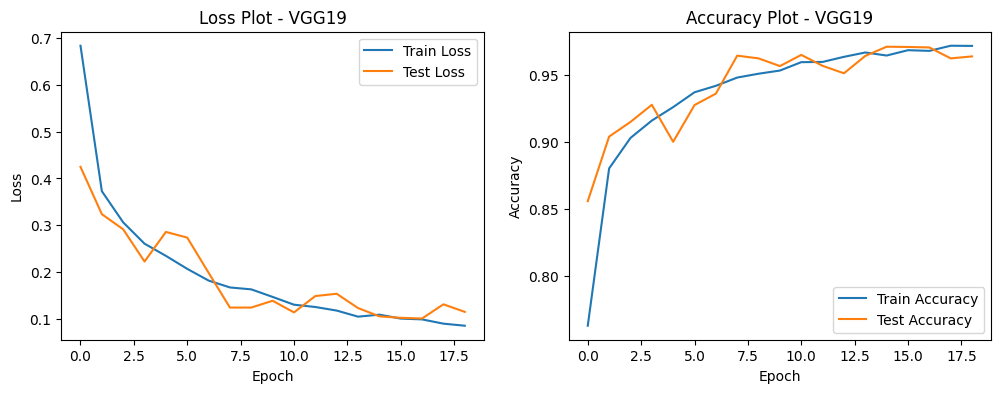

In [40]:
# Plot training and test loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(vgg19_model.history.history['loss'], label='Train Loss')
plt.plot(vgg19_model.history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot - VGG19')
plt.legend()

# Plot training and test accuracy
plt.subplot(1,2,2)
plt.plot(vgg19_model.history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(vgg19_model.history.history['val_categorical_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot - VGG19')
plt.legend()
plt.show()

In [41]:
# 4. Transfer Learning using VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers:
    layer.trainable = True

input = Input(shape=(64, 64, 13)) # Defining input layer
x = Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 13))(input)
x = base_model(x) # Passing the modified input through the base model
x = Flatten()(x)  # Flattening the output
x = Dense(256, activation='relu')(x) # Adding additional dense layers
output = Dense(num_classes, activation='softmax')(x) # Output layer

VGG16_model = Model(name='Landcover_classification',inputs=input, outputs=output)
VGG16_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy', metrics=['categorical_accuracy']) # Compiling the model
VGG16_model.summary(line_length=100,show_trainable=True)

58889256/58889256 [==============================] - 0s 0us/step
Model: "Landcover_classification"
_______________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        Trainable  
 input_16 (InputLayer)                       [(None, 64, 64, 13)]                    0              Y          
                                                                                                               
 conv2d_579 (Conv2D)                         (None, 64, 64, 3)                       354            Y          
                                                                                                               
 vgg16 (Functional)                          (None, 2, 2, 512)                       14714688       Y          
                                                                                                               
 flat

In [42]:
checkpoint     = ModelCheckpoint('/content/drive/MyDrive/Landcover_recognition/vgg16_model.h5',
                                 monitor='val_categorical_accuracy', save_best_only=True, mode='max',verbose=1)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4,
                               mode='max',verbose=1)
lr_handling    = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.95,
                                   patience=2,mode='max',verbose=1)
VGG16_model.fit(train_generator,
    epochs=60,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping,lr_handling],verbose=1)

Epoch 1/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.5739 - categorical_accuracy: 0.8039
Epoch 1: val_categorical_accuracy improved from -inf to 0.89815, saving model to /content/drive/MyDrive/Landcover_recognition/vgg16_model.h5
1350/1350 [==============================] - 96s 68ms/step - loss: 0.5736 - categorical_accuracy: 0.8040 - val_loss: 0.3197 - val_categorical_accuracy: 0.8981 - lr: 1.0000e-04
Epoch 2/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.3097 - categorical_accuracy: 0.8990
Epoch 2: val_categorical_accuracy improved from 0.89815 to 0.92685, saving model to /content/drive/MyDrive/Landcover_recognition/vgg16_model.h5
1350/1350 [==============================] - 67s 50ms/step - loss: 0.3096 - categorical_accuracy: 0.8990 - val_loss: 0.2247 - val_categorical_accuracy: 0.9269 - lr: 1.0000e-04
Epoch 3/60
1350/1350 [==============================] - ETA: 0s - loss: 0.2573 - categorical_accuracy: 0.9144
Epoch 3: val_categorical_accuracy

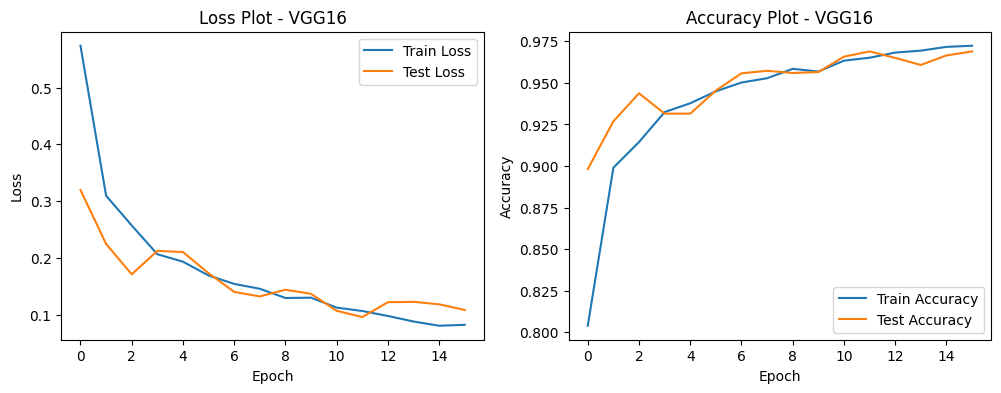

In [43]:
# Plot training and test loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(VGG16_model.history.history['loss'], label='Train Loss')
plt.plot(VGG16_model.history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot - VGG16')
plt.legend()

# Plot training and test accuracy
plt.subplot(1,2,2)
plt.plot(VGG16_model.history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(VGG16_model.history.history['val_categorical_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot - VGG16')
plt.legend()
plt.show()

In [44]:
#  5. Transfer Learning using Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))
for layer in base_model.layers:
    layer.trainable = True

input = Input(shape=(64, 64, 13)) # Defining input layer
x = Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 13))(input)
x = base_model(x) # Passing the modified input through the base model
x = Flatten()(x)  # Flattening the output
x = Dense(256, activation='relu')(x) # Adding additional dense layers
output = Dense(num_classes, activation='softmax')(x) # Output layer

Xception_model = Model(name='Landcover_classification',inputs=input, outputs=output)
Xception_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy', metrics=['categorical_accuracy']) # Compiling the model
Xception_model.summary(line_length=100,show_trainable=True)

83683744/83683744 [==============================] - 1s 0us/step
Model: "Landcover_classification"
_______________________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        Trainable  
 input_18 (InputLayer)                       [(None, 64, 64, 13)]                    0              Y          
                                                                                                               
 conv2d_584 (Conv2D)                         (None, 64, 64, 3)                       354            Y          
                                                                                                               
 xception (Functional)                       (None, 3, 3, 2048)                      20861480       Y          
                                                                                                               
 flat

In [45]:
checkpoint     = ModelCheckpoint('/content/drive/MyDrive/Landcover_recognition/xception_model.h5',
                                 monitor='val_categorical_accuracy',
                                 mode='max',save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, mode='max',
                               verbose=1)
lr_handling    = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.95,
                                   patience=2,mode='max',verbose=1)
Xception_model.fit(train_generator,
    epochs=60,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping,lr_handling],verbose=1)

Epoch 1/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.7615 - categorical_accuracy: 0.7438
Epoch 1: val_categorical_accuracy improved from -inf to 0.86593, saving model to /content/drive/MyDrive/Landcover_recognition/xception_model.h5
1350/1350 [==============================] - 100s 56ms/step - loss: 0.7613 - categorical_accuracy: 0.7439 - val_loss: 0.7313 - val_categorical_accuracy: 0.8659 - lr: 1.0000e-04
Epoch 2/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.3393 - categorical_accuracy: 0.8889
Epoch 2: val_categorical_accuracy did not improve from 0.86593
1350/1350 [==============================] - 67s 50ms/step - loss: 0.3392 - categorical_accuracy: 0.8889 - val_loss: 0.5812 - val_categorical_accuracy: 0.8391 - lr: 1.0000e-04
Epoch 3/60
1349/1350 [============================>.] - ETA: 0s - loss: 0.2834 - categorical_accuracy: 0.9051
Epoch 3: val_categorical_accuracy improved from 0.86593 to 0.93519, saving model to /content/drive/MyDrive/Lan

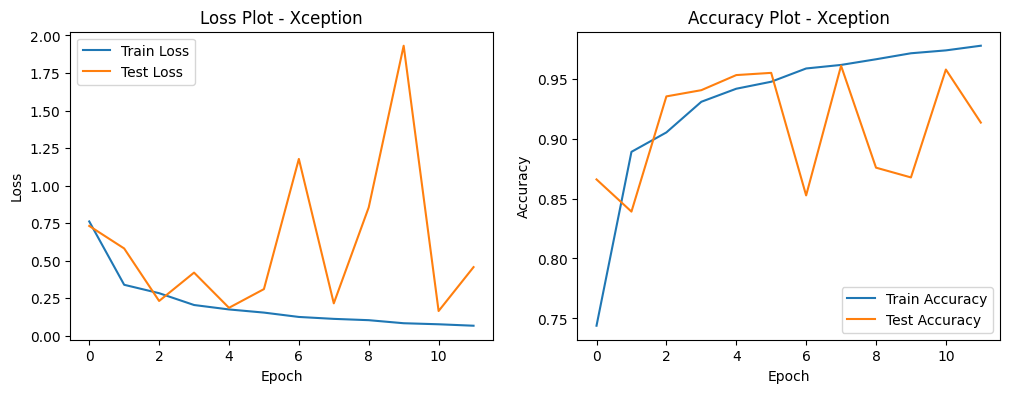

In [46]:
# Plot training and test loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Xception_model.history.history['loss'], label='Train Loss')
plt.plot(Xception_model.history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot - Xception')
plt.legend()

# Plot training and test accuracy
plt.subplot(1,2,2)
plt.plot(Xception_model.history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(Xception_model.history.history['val_categorical_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot - Xception')
plt.legend()
plt.show()

In [48]:
table = PrettyTable()
table.field_names = ["Model", "Train Loss", "Test Loss",
                     "Train Accuracy","Test Accuracy"]

table.add_row(["Custom CNN Model",0.1567,0.1438,0.9460,0.9515])
table.add_row(["VGG19",0.1086,0.1051,0.9647,0.9713])
table.add_row(["VGG16",0.1067,0.0961,0.9651,0.9689])
table.add_row(["Xception",0.1122,0.2156,0.9614,0.9607])

# Print the table
print(table)

+------------------+------------+-----------+----------------+---------------+
|      Model       | Train Loss | Test Loss | Train Accuracy | Test Accuracy |
+------------------+------------+-----------+----------------+---------------+
| Custom CNN Model |   0.1567   |   0.1438  |     0.946      |     0.9515    |
|      VGG19       |   0.1086   |   0.1051  |     0.9647     |     0.9713    |
|      VGG16       |   0.1067   |   0.0961  |     0.9651     |     0.9689    |
|     Xception     |   0.1122   |   0.2156  |     0.9614     |     0.9607    |
+------------------+------------+-----------+----------------+---------------+


It can be observed from the above results that VGG19 model performed better than any other model considering highest test accuracy. It can be considered as the best model for predictions.

In [49]:
# Loading the best model
best_model = load_model('/content/drive/MyDrive/Landcover_recognition/vgg19_model.h5')

In [50]:
# Creating a sample from the test data for predictions
test_sample = test.sample(15)

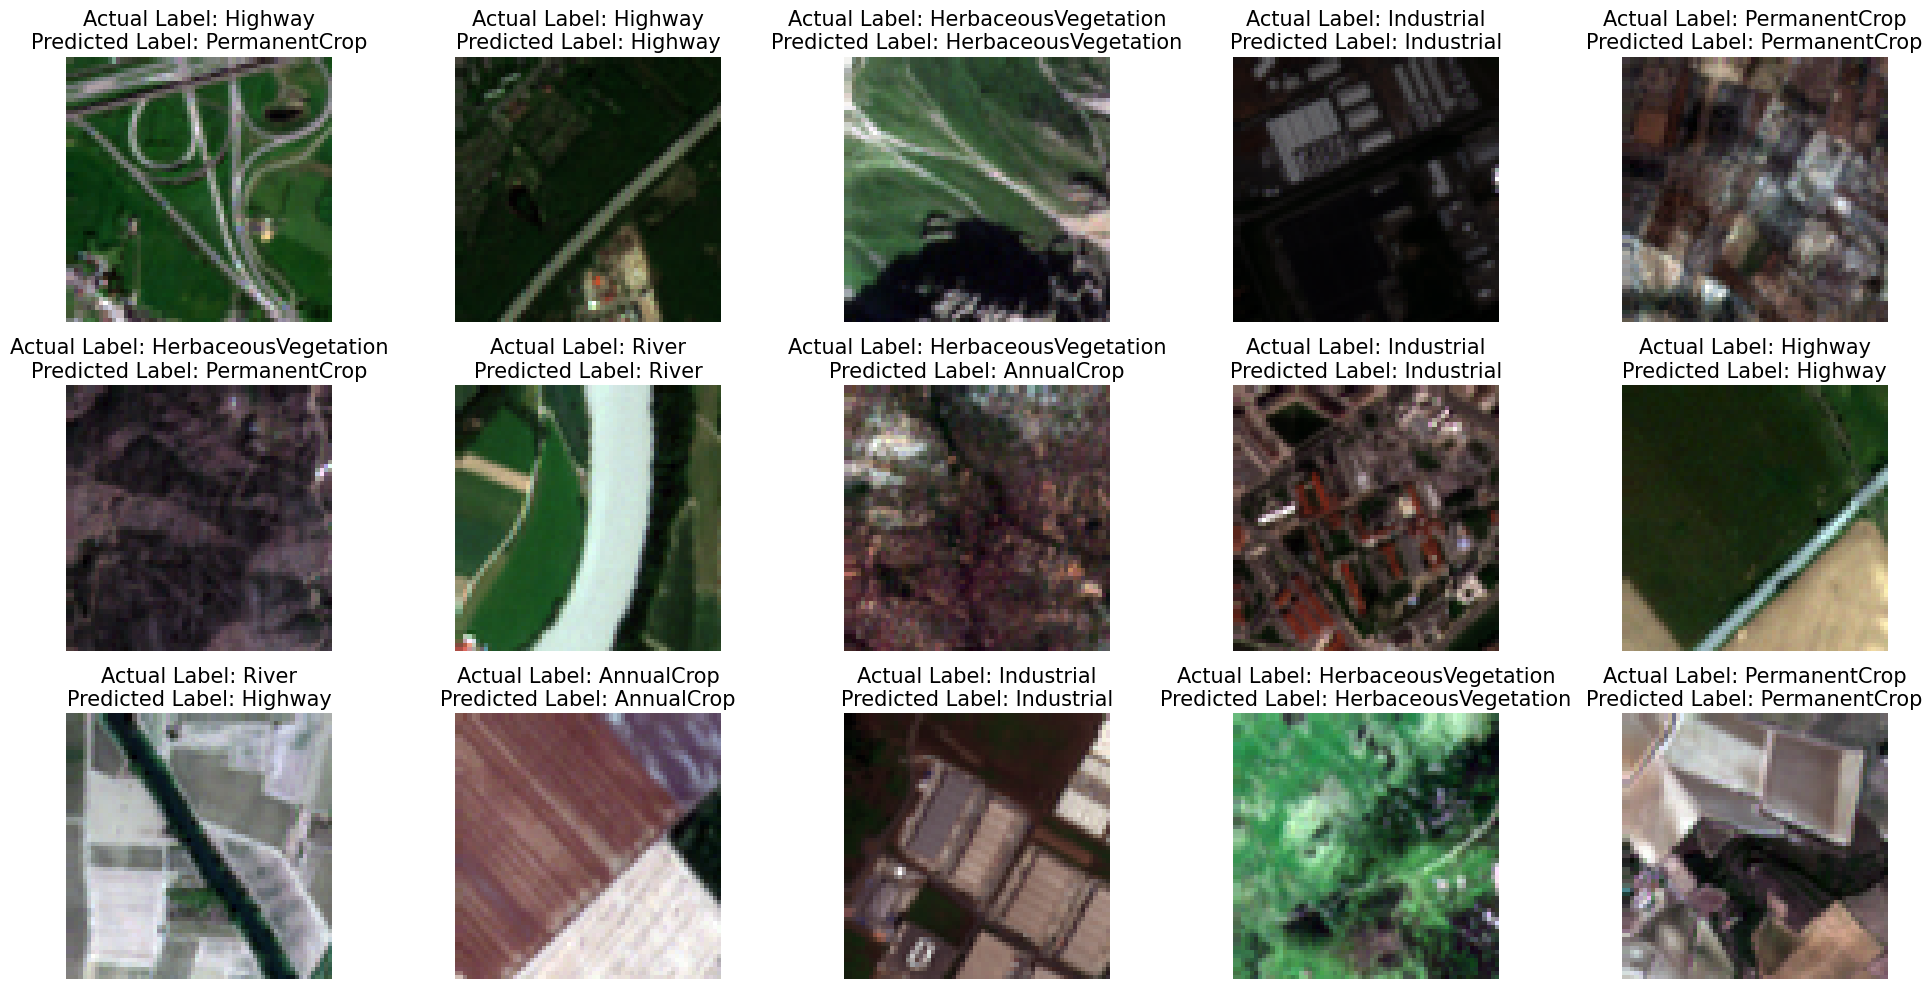

In [51]:
# Predictions on sample test data
i = 0
plt.figure(figsize=(20,10))
for j in test_sample['image_path'].tolist():
  tif_data = tifffile.imread(j).astype('float32') / 1500
  bands    = np.transpose(tif_data, (2, 0, 1))[[3,2,1],:,:] # Extracting RGB Channels
  scaled_bands = [(band - band.min()) / (band.max() - band.min()) for band in bands]
  rgb_image = np.dstack(scaled_bands)
  predicted_label = train_generator.get_class_labels()[np.argmax(\
      best_model.predict(tif_data[np.newaxis,:,:,:],verbose=3))]
  plt.subplot(3,5,i+1)
  plt.imshow(rgb_image)
  plt.axis('off')
  plt.title('Actual Label: {}\nPredicted Label: {}'.format(test_sample['label'].\
                                      tolist()[i], predicted_label), fontsize=15)
  i = i + 1
plt.tight_layout()
plt.show()

In [52]:
# Make predictions on test data using your model
test_predictions = best_model.predict(test_generator,verbose=1)
# Convert predictions from one-hot encoded format to labels
test_predicted_labels = np.argmax(test_predictions, axis=1)
# Get true labels from the test data generator
test_true_labels = test_generator.labels
# Label names
label_names = test_generator.get_class_labels()

338/338 [==============================] - 7s 18ms/step


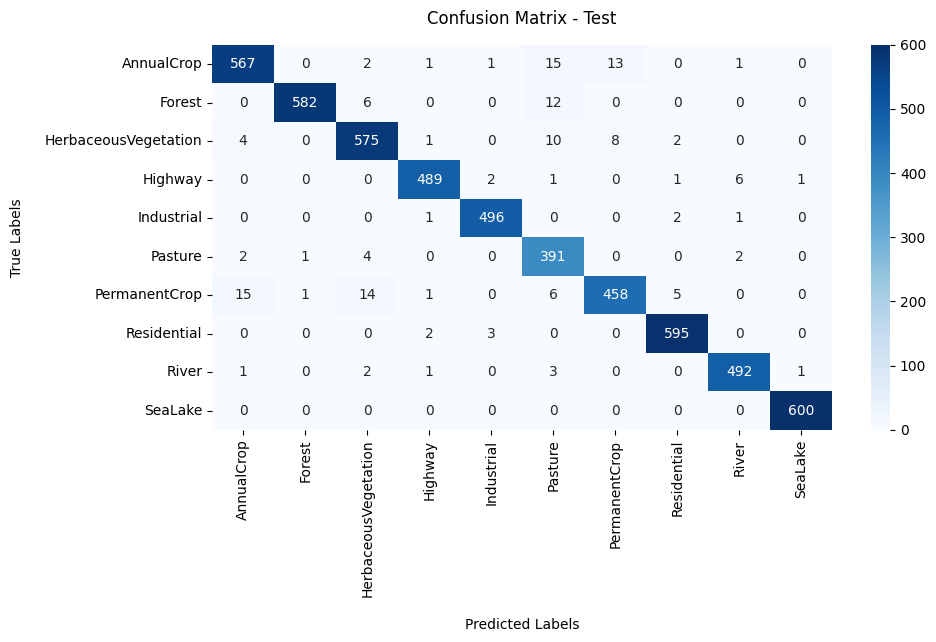

In [53]:
# Compute the confusion matrix
test_conf_matrix = confusion_matrix(test_true_labels,test_predicted_labels)
# Create a DataFrame from the confusion matrix with label names as column and index names
test_conf_df = pd.DataFrame(test_conf_matrix, index=label_names, columns=label_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(test_conf_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels',labelpad=15)
plt.ylabel('True Labels',labelpad=15)
plt.title('Confusion Matrix - Test',pad=15)
plt.show()

In [54]:
# Make predictions on train data using your model
train_predictions = best_model.predict(train_generator,verbose=1)
# Convert predictions from one-hot encoded format to labels
train_predicted_labels = np.argmax(train_predictions, axis=1)
# Get true labels from the train data generator
train_true_labels = train_generator.labels

1350/1350 [==============================] - 57s 42ms/step


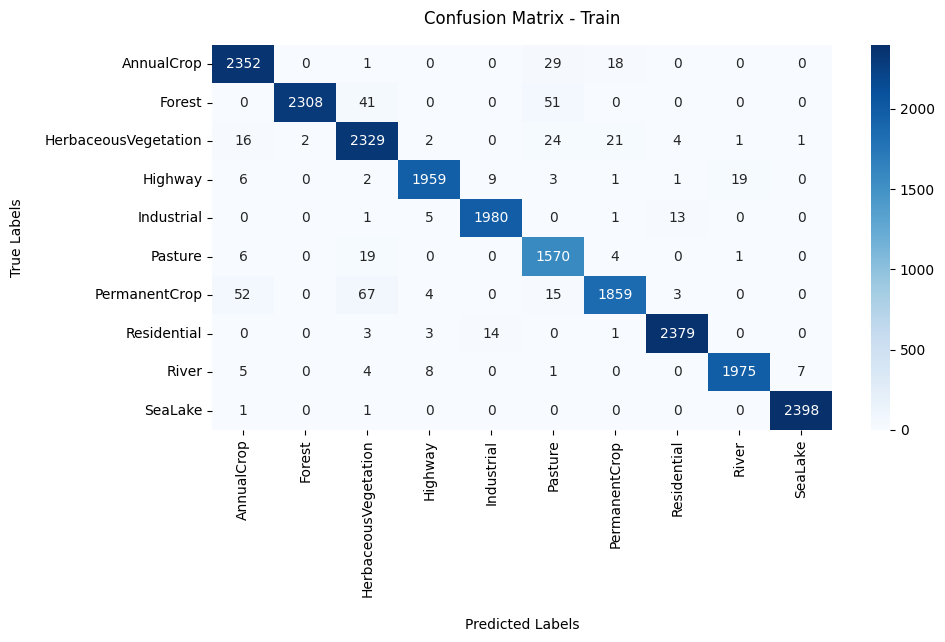

In [55]:
# Compute the confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels,train_predicted_labels)
# Create a DataFrame from the confusion matrix with label names as column and index names
train_conf_df = pd.DataFrame(train_conf_matrix, index=label_names, columns=label_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(train_conf_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels',labelpad=15)
plt.ylabel('True Labels',labelpad=15)
plt.title('Confusion Matrix - Train',pad=15)
plt.show()